# Environement configuration

In [ ]:
# Install required packages

!pip install datasets
! pip install transformers==4.27.4
! pip install tokenizers==0.13.3
!pip install seqeval

In [ ]:
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
#import nltk
#from nltk.corpus import stopwords
#nltk.download ('stopwords')
import tensorflow as tf
import nltk
nltk.download('punkt')
import datasets 
import numpy as np 
from transformers import BertTokenizerFast 
from transformers import DataCollatorForTokenClassification 
from transformers import AutoModelForTokenClassification 
from datasets import DatasetDict, Dataset
import torch

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Loading & Preprocessing data

In [ ]:
# Connect to Google Drive for later use
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
f = open('/content/drive/Shareddrives/CRP_SG/Model_selection/master_dict_output_BERT_patterned_v2.json')
data = json.load(f)

In [ ]:
# run this cell if you want to select a subset of your data
def select_random_part(data, n_max): 
  new_dict = {}
  annotations = np.array(data['annotations'])
  np.random.shuffle(annotations)
  annotations = annotations[:n_max]
  new_dict['annotations'] = annotations
  new_dict['classes'] = data['classes']
  return new_dict

data = select_random_part(data, 10000)

In [ ]:
# Explore dataset
print(data.keys())
print(data['annotations'][0])
print(data['classes'])

dict_keys(['annotations', 'classes'])
[',*+_~%. ({ Grunt Kai / de /£-)][;\'/<^@ ?>`!=|:}$&#"€ NL67 1099 0897 2377 08'
 {'id': [72557], 'tokens': [',*+_~%.', '({', 'Grunt', 'Kai', '/', 'de', "/£-)][;'/<^@", '?>`!=|:}$&#"€', 'NL67', '1099', '0897', '2377', '08'], 'ner_tags': [7, 8, 1, 2, 2, 2, 7, 8, 5, 6, 6, 6, 6]}]
{'O': 0, 'B-NAME': 1, 'I-NAME': 2, 'B-LOC': 3, 'I-LOC': 4, 'B-ACC': 5, 'I-ACC': 6, 'B-MISC': 7, 'I-MISC': 8}


In [ ]:
data_dic = [x[1] for x in data['annotations']]

In [ ]:
# Split the data into training and test sets
train_data, test_data = train_test_split(data_dic, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [ ]:
print(len(train_data), len(val_data), len(test_data))

6400 1600 2000


In [ ]:
# Convert the train, val, and test data to Dataset objects
train_dataset = Dataset.from_dict({"id": [d['id'] for d in train_data], "tokens": [d["tokens"] for d in train_data], "ner_tags": [d["ner_tags"] for d in train_data]})
val_dataset = Dataset.from_dict({"id": [d['id'] for d in val_data], "tokens": [d["tokens"] for d in val_data], "ner_tags": [d["ner_tags"] for d in val_data]})
test_dataset = Dataset.from_dict({"id": [d['id'] for d in test_data], "tokens": [d["tokens"] for d in test_data], "ner_tags": [d["ner_tags"] for d in test_data]})

# Create the DatasetDict object
dataset_sg = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})


In [ ]:
print(dataset_sg)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 6400
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 2000
    })
})


In [ ]:
# Preprocessing
def tokenize_and_align_labels(examples, label_all_tokens=True): 
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True) 
    labels = [] 
    for i, label in enumerate(examples["ner_tags"]): 
        word_ids = tokenized_inputs.word_ids(batch_index=i) 
        # word_ids() => Return a list mapping the tokens
        # to their actual word in the initial sentence.
        # It Returns a list indicating the word corresponding to each token. 
        previous_word_idx = None 
        label_ids = []
        # Special tokens like `<s>` and `<\s>` are originally mapped to None 
        # We need to set the label to -100 so they are automatically ignored in the loss function.
        for word_idx in word_ids: 
            if word_idx is None: 
                # set –100 as the label for these special tokens
                label_ids.append(-100)
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            elif word_idx != previous_word_idx:
                # if current word_idx is != prev then its the most regular case
                # and add the corresponding token                 
                label_ids.append(label[word_idx]) 
            else: 
                # to take care of sub-words which have the same word_idx
                # set -100 as well for them, but only if label_all_tokens == False
                label_ids.append(label[word_idx] if label_all_tokens else -100) 
                # mask the subword representations after the first subword
                 
            previous_word_idx = word_idx 
        labels.append(label_ids) 
    tokenized_inputs["labels"] = labels 
    return tokenized_inputs 

In [ ]:
# Setting gpu devide
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained("/content/drive/Shareddrives/CRP_SG/Model_selection/tokenizer_v2")

In [ ]:
# Access the first example text from the 'train' split of the dataset
example_text = dataset_sg['train'][0]

# Print the tokens of the example text
print(example_text["tokens"])

# Tokenize the input text using the tokenizer, splitting it into words
tokenized_input = tokenizer(example_text["tokens"], is_split_into_words=True)

# Convert the token IDs to their corresponding tokens
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

# Retrieve the word IDs assigned by the tokenizer
word_ids = tokenized_input.word_ids()

# Print the word IDs
print(word_ids)
# Print the tokenized input
tokenized_input

['FR8266572044170855710079395', 'bert-Vincent', 'Collin-la-Foret', 'France', '59452', '837', 'Guerin', 'avenue', 'A', '*:]$,%`?}£', 'lain', 'Thierry', 'He']
[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 11, 12, None]


{'input_ids': [101, 10424, 2620, 23833, 26187, 2581, 11387, 22932, 16576, 2692, 27531, 28311, 18613, 2581, 2683, 23499, 2629, 14324, 1011, 6320, 22180, 1011, 2474, 1011, 18921, 2102, 2605, 5354, 19961, 2475, 6640, 2581, 19739, 23282, 3927, 1037, 1008, 1024, 1033, 1002, 1010, 1003, 1036, 1029, 1065, 1069, 21110, 2078, 26413, 2002, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
q = tokenize_and_align_labels(dataset_sg['train'][4:5]) 
print(q) 

{'input_ids': [[101, 9686, 19481, 2575, 21619, 2620, 22907, 2683, 14142, 2683, 2683, 2581, 10790, 2575, 2581, 2581, 12521, 2629, 2128, 2050, 11865, 6238, 2474, 9057, 2080, 1010, 3081, 2139, 1007, 1024, 1064, 1063, 1011, 1031, 2030, 11410, 13101, 1020, 13163, 23380, 23499, 3577, 21877, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 2, 2, 2, 2, 2, 2, 3, 4, 7, 7, 7, 7, 7, 7, 3, 3, 4, 4, 4, 4, 4, 4, 1, -100]]}


In [ ]:
tokenized_datasets = dataset_sg.map(tokenize_and_align_labels, batched=True)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Define a function to select specific features from an example
def select_features(example):
    # Create a sub-dataset using the selected features
    sub_dataset =  Dataset.from_dict({
        'id': example['id'],
        'input_ids': example['input_ids'],
        'token_type_ids': example['token_type_ids'],
        'attention_mask': example['attention_mask'],
        'labels': example['labels']})
    return sub_dataset

# Select features for the 'train' split of the tokenized datasets
train_tokenized_datasets = select_features(tokenized_datasets['train'])

# Select features for the 'validation' split of the tokenized datasets
val_tokenized_datasets = select_features(tokenized_datasets['validation'])

# Select features for the 'test' split of the tokenized datasets
test_tokenized_datasets = select_features(tokenized_datasets['test'])

In [ ]:
from transformers import DataCollatorForTokenClassification
BATCH_SIZE = 64

# Initialise datacollator object
data_collator = DataCollatorForTokenClassification(tokenizer)

# Create Dataloader instance for training, validation and test sets
train_dataloader = DataLoader(train_tokenized_datasets, collate_fn=data_collator, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_tokenized_datasets, collate_fn=data_collator, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_tokenized_datasets, collate_fn=data_collator, batch_size = BATCH_SIZE)

In [ ]:
label_list = ['O', 'B-NAME', 'I-NAME', 'B-LOC', 'I-LOC', 'B-ACC', 'I-ACC', 'B-MISC', 'I-MISC']
metric = datasets.load_metric("seqeval")

def compute_metrics(eval_preds): 
    pred_logits, labels = eval_preds 
    
    pred_logits = np.argmax(pred_logits, axis=2) 
    # the logits and the probabilities are in the same order,
    # so we don’t need to apply the softmax
    
    # We remove all the values where the label is -100
    predictions = [ 
        [label_list[eval_preds] for (eval_preds, l) in zip(prediction, label) if l != -100] 
        for prediction, label in zip(pred_logits, labels) 
    ] 
    
    true_labels = [ 
      [label_list[l] for (eval_preds, l) in zip(prediction, label) if l != -100] 
       for prediction, label in zip(pred_logits, labels) 
   ] 
    results = metric.compute(predictions=predictions, references=true_labels) 
    return { 
   "precision": results["overall_precision"], 
   "recall": results["overall_recall"], 
   "f1": results["overall_f1"], 
  "accuracy": results["overall_accuracy"], 
  } 

<ipython-input-21-e2ff1a70f8ec>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric("seqeval")


# BiLSTM Model

## Model definition and training

In [ ]:
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


# Load the saved model and the saved tokenizer


"""

bert_model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels=9, output_hidden_states=True).to(device)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", device=device)
"""
class BiLSTM(nn.Module):
    def __init__(self, num_classes, hidden_size=30, num_layers=2):
        super(BiLSTM, self).__init__()
        self.embedding_dim = 768  # BERT embedding dimension
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define the bi-LSTM layer
        self.bilstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_size, 
                              num_layers=self.num_layers, batch_first=True, dropout=0.2, 
                              bidirectional=True)
        
        # Define the output layer
        self.fc = nn.Linear(in_features=self.hidden_size*2, out_features=num_classes)
        self.softmax = nn.Softmax(dim=2)
    
    def predict_labels(self, output, attention_mask):
        """
        output: batch_size, max_sentence_len, tag_num
        mask: same label data
        batch_label: batch_size, sentence_label
        """


        
    def forward(self, input_ids, attention_mask):
        # input_ids: [batch_size, max_seq_length]
        # attention_mask: [batch_size, max_seq_length]
        
        # Check if input_ids is not empty
        if input_ids.shape[1] == 0:
            raise ValueError("Input tokens are empty")
        
        # Obtain BERT embeddings for the input tokens
        bert_output = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Check if bert_output.hidden_states is not None
        if bert_output.hidden_states is None:
            raise ValueError("No BERT embeddings found")
        
        embeddings = bert_output.hidden_states[-1] # Shape (batch_size, max_sequence_len, embedding_dim)
        #print(embeddings.shape)
        output, _ = self.bilstm(embeddings) # Shape (batch_size, max_sequence_len, hidden_dim*2)
        #print(output.shape)
        output = self.fc(output) # Shape (batch_size, max_sequence_len, 9)
        #print(output.shape)
        output = self.softmax(output)
        """
        # Sort the sequences by length in decreasing order for pack_padded_sequence
        lengths = attention_mask.sum(dim=1).tolist()
        sorted_lengths, sorted_idx = torch.sort(torch.tensor(lengths), descending=True)
        embeddings = embeddings[sorted_idx]
        
        # Pack the sequences and run through the bi-LSTM layer
        packed_embeddings = pack_padded_sequence(embeddings, sorted_lengths, batch_first=True, enforce_sorted=False)
        output, (hidden, cell) = self.bilstm(packed_embeddings)
        padded_output, _ = pad_packed_sequence(output, batch_first=True)
        
        # Concatenate the forward and backward LSTM outputs and pass through the output layer
        logits = self.fc(padded_output)
        """
        #print(f'Output shape {output.shape}')
        return output
        

In [ ]:
def predict_labels(output, attention_mask) :
        """
        output: batch_size, max_sentence_len, tag_num
        mask: same label data
        batch_label: batch_size, sentence_label
        """
        pre_label = []
        pre_label_pad = output.argmax(2)
        for i in range(attention_mask.shape[0]):
            sent_label = []
            for j in range(attention_mask.shape[1]):
                if attention_mask[i, j] == 1:
                    sent_label.append(pre_label_pad[i, j].item())
            sent_label = sent_label[1:len(sent_label)-1]
            pre_label.append(sent_label)

        return pre_label

In [ ]:
def convert_labels(labels):
  new_labels = []
  for liste in labels :
    liste = list(liste)
    while -100 in liste :
      liste.remove(-100)
    liste = [int(i) for i in liste]
    new_labels.append(liste)
  return new_labels

In [ ]:
def compute_scores(preds, original_labels):

    c = 0
    total = 0
    
    for i in range(len(preds)):
        c += sum(1 for pred, label in zip(preds[i], original_labels[i]) if pred == label)
        total += len(preds[i])
    
    return c, total


In [ ]:
def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]

In [ ]:
import torch
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from collections import defaultdict


# Define the training loop
def train(model, train_dataloader, valid_dataloader, criterion, optimizer, epochs=3):
    all_scores = defaultdict(list)
    val_accuracy = []


    # Train the model for the specified number of epochs
    for epoch in range(epochs):
        total_prediction = []
        total_labels = []
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Set the model to training mode
        model.train()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0
        running_total = 0 

        # Iterate over the training DataLoader
        for batch in tqdm(train_dataloader, desc="Training"):
            id = batch.id
            inputs = batch.input_ids
            
            token_type_ids = batch.token_type_ids
            attention_masks = batch.attention_mask
            labels = batch.labels

            # Zero the gradients
            optimizer.zero_grad()

            # Move the inputs and labels to the GPU if available
            
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(inputs, attention_masks)

            batch_size, sequence_length, num_classes = outputs.size()

            loss = criterion(outputs.view(-1, num_classes), labels.view(-1))

            loss.backward()
            optimizer.step()
            #preds = predict_labels(outputs, attention_masks)
            #print(outputs.shape)
            preds = predict_labels(outputs, attention_masks)
            original_labels = convert_labels(labels)
            
            
            total_prediction = total_prediction + flatten_list(preds)
            total_labels = total_labels + flatten_list(original_labels)

            #print(preds.shape)           
            #print(labels.shape)
            """
            # Flatten labels to match expected format for CrossEntropyLoss
            labels = labels.view(-1)

            
            # Calculate the loss
            

            # Backward pass and optimization step
            """

            # Update the running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            corrects_batch, total_batch = compute_scores(preds, original_labels)
            running_corrects += corrects_batch
            running_total += total_batch

        # Calculate the training loss and accuracy
        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = accuracy_score(total_labels, total_prediction)

        print(f"Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f}")

        # Evaluate the model on the validation set
        val_loss, scores = evaluate(model, valid_dataloader)


        print(f"Val Loss: {val_loss:.4f} Val Acc: {scores['Accuracy_score']:.4f}")

        all_scores['Training_loss'].append(epoch_loss)
        all_scores['Validation_loss'].append(val_loss)
        all_scores['F1_score'].append(scores['F1_score'])
        all_scores['Precision'].append(scores['Precision'])
        all_scores['Recall'].append(scores['Recall'])
        all_scores['Accuracy_score'].append(scores['Accuracy_score'])

    index_names = ['Epoch' + ' ' + f'{i}' for i in range(epochs)]

    return pd.DataFrame(all_scores, index=index_names)


#Define a function to evaluate the model on a dataset

def evaluate(model, dataloader):
    
    total_prediction = []
    total_labels = []
    # Set the model to evaluation mode
    model.eval()

    # Initialize the running loss and accuracy
    running_loss = 0.0
    running_corrects = 0
    running_total = 0

    # Disable gradient calculation to speed up inference
    with torch.no_grad():
        # Iterate over the validation DataLoader
        for batch in tqdm(dataloader, desc="Validation"):
            id = batch.id
            inputs = batch.input_ids
            token_type_ids = batch.token_type_ids
            attention_masks = batch.attention_mask
            labels = batch.labels

            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(inputs, attention_masks)

            batch_size, sequence_length, num_classes = outputs.size()

            loss = criterion(outputs.view(-1, num_classes), labels.view(-1))

            preds = predict_labels(outputs, attention_masks)
            original_labels = convert_labels(labels)

            total_prediction = total_prediction + flatten_list(preds)
            total_labels = total_labels + flatten_list(original_labels)
            # Update the running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            corrects_batch, total_batch = compute_scores(preds, original_labels)
            running_corrects += corrects_batch
            running_total += total_batch

    # Calculate the validation loss and accuracy
    f1 = f1_score(total_labels, total_prediction,average='weighted')
    acc = accuracy_score(total_labels, total_prediction)
    prec = precision_score(total_labels, total_prediction, average='weighted')
    rec = recall_score(total_labels, total_prediction, average='weighted')
    scores = {'F1_score':f1, 'Precision':prec, 'Recall':rec, 'Accuracy_score':acc}
    epoch_loss = running_loss / len(val_dataloader.dataset)

    return epoch_loss, scores

In [ ]:
# Define the optimizer and the loss function
lr = 1e-2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bert_model = AutoModelForTokenClassification.from_pretrained("/content/drive/Shareddrives/CRP_SG/Model_selection/ner_model_v2", num_labels=9, output_hidden_states=True).to(device)

tokenizer = BertTokenizerFast.from_pretrained("/content/drive/Shareddrives/CRP_SG/Model_selection/tokenizer_v2")


model = BiLSTM(9).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()


## Fine-Tuning

In [ ]:
# The best results are obtained with hidden_sizes of 30 and with num_layers of 2

###DO NOT EXECUTE UNLESS YOU WANT TO PERFORM HYPERPARAMETERS TUNNING


from sklearn.model_selection import GridSearchCV

hidden_sizes = [10, 20, 30, 50, 100]
num_layers = [1, 2, 5, 10]
perf_dict = {}

for hidden_size in hidden_sizes : 
  for num_layer in num_layers : 
    model = BiLSTM(num_classes=9, hidden_size = hidden_size, num_layers = num_layer).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    accuracy = train(model, train_dataloader, val_dataloader, criterion, optimizer, epochs=2)
    perf_dict[(hidden_sizes, num_layers)] = accuracy


max = 0 
for key, value in perf_dict.items() :
  if value > max :
    max = value
    best_hyper = key

print(f'The best results are obtained with hidden_sizes of {best_hyper[0]} and with num_layers of {best_hyper[1]}')


## Final training - Do not execute

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, epochs=3)

Epoch 1/3


Training: 100%|██████████| 100/100 [09:59<00:00,  6.00s/it]


Train Loss: 1.4980 Train Acc: 0.9024


Validation: 100%|██████████| 25/25 [02:57<00:00,  7.11s/it]


Val Loss: 1.4353 Val Acc: 0.9367
Epoch 2/3


Training: 100%|██████████| 100/100 [10:31<00:00,  6.32s/it]


Train Loss: 1.4342 Train Acc: 0.9376


Validation: 100%|██████████| 25/25 [02:09<00:00,  5.17s/it]


Val Loss: 1.4358 Val Acc: 0.9361
Epoch 3/3


Training: 100%|██████████| 100/100 [09:41<00:00,  5.81s/it]


Train Loss: 1.4340 Train Acc: 0.9378


Validation: 100%|██████████| 25/25 [02:04<00:00,  4.97s/it]

Val Loss: 1.4355 Val Acc: 0.9363


,Training_loss,Validation_loss,F1_score,Precision,Recall,Accuracy_score
Epoch 0,1.498020,1.435343,0.936479,0.936747,0.936657,0.936657
Epoch 1,1.434224,1.435791,0.936208,0.936480,0.936098,0.936098
Epoch 2,1.433980,1.435498,0.935896,0.936302,0.936258,0.936258


## Saving the trained model, loading it and evaluating it

In [ ]:
torch.save(model.state_dict(), "/content/drive/Shareddrives/CRP_SG/Model_selection/BiLSTM_model/BiLSTM_Model_small_dataset")

In [ ]:
model = BiLSTM(9).to(device)
model.load_state_dict(torch.load("/content/drive/Shareddrives/CRP_SG/Model_selection/BiLSTM_model/BiLSTM_Model_small_dataset"))

<All keys matched successfully>

In [ ]:
test_loss, scores = evaluate(model, test_dataloader)
print(scores)

Validation: 100%|██████████| 32/32 [03:11<00:00,  6.00s/it]


{'F1_score': 0.9359464092364825, 'Precision': 0.9360493845458295, 'Recall': 0.9362074100933708, 'Accuracy_score': 0.9362074100933708}


## Eploring Misclassificaitons

In [ ]:
def predictions_flattened(model, dataloader):
    total_prediction = []
    total_labels = []
    # Set the model to evaluation mode
    model.eval()

    # Initialize the running loss and accuracy
    running_loss = 0.0
    running_corrects = 0
    running_total = 0

    # Disable gradient calculation to speed up inference
    with torch.no_grad():
        # Iterate over the validation DataLoader
        for batch in tqdm(dataloader, desc="Evaluation"):
            id = batch.id
            inputs = batch.input_ids
            token_type_ids = batch.token_type_ids
            attention_masks = batch.attention_mask
            labels = batch.labels

            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(inputs, attention_masks)

            batch_size, sequence_length, num_classes = outputs.size()

            loss = criterion(outputs.view(-1, num_classes), labels.view(-1))

            preds = predict_labels(outputs, attention_masks)
            original_labels = convert_labels(labels)

            total_prediction = total_prediction + flatten_list(preds)
            total_labels = total_labels + flatten_list(original_labels)


    return total_prediction, total_labels

In [ ]:
predicted_labels, true_labels = predictions_flattened(model, test_dataloader)

Evaluation: 100%|██████████| 32/32 [02:51<00:00,  5.36s/it]


In [ ]:
index_to_class = {}
for key, value in data['classes'].items():
  index_to_class[value] = key

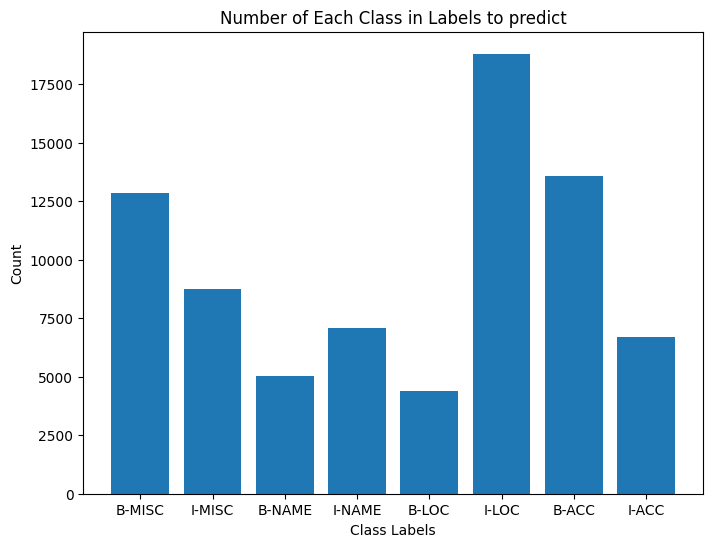

In [ ]:
class_counts = {}
for label in true_labels:
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

# Extract the class labels and their corresponding counts
class_labels = [index_to_class[i] for i in list(class_counts.keys())]
class_values = list(class_counts.values())

# Create a bar plot of class proportions
plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_values)
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Number of Each Class in Labels to predict')
plt.show()

In [ ]:
false_pred = [true_labels[i] if predicted_labels[i] != true_labels[i] else -1 for i in range(len(predicted_labels)) ]
while -1 in false_pred :
  false_pred.remove(-1)

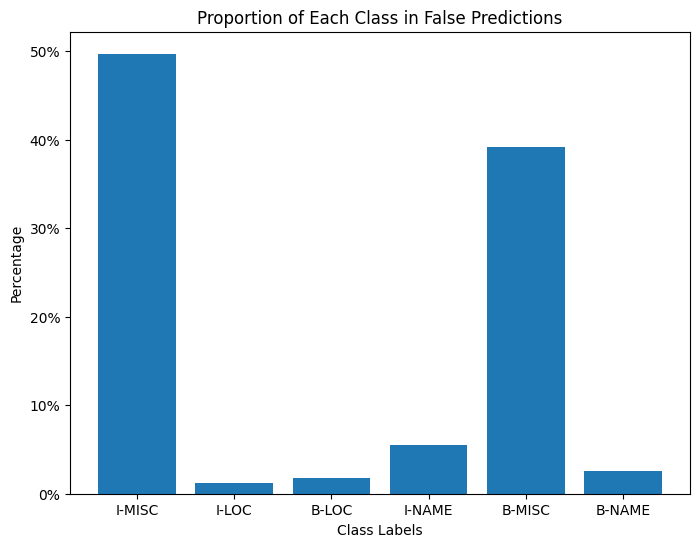

In [ ]:
import matplotlib.ticker as mticker

# Count the occurrences of each class in false_pred
class_counts = {}
for label in false_pred:
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

# Calculate the total count
total_count = sum(class_counts.values())

# Calculate the percentage for each class
class_labels = [index_to_class[label] for label in class_counts.keys()]
class_percentages = [(count / total_count) * 100 for count in class_counts.values()]

# Create a bar plot of class proportions
plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_percentages)
plt.xlabel('Class Labels')
plt.ylabel('Percentage')
plt.title('Proportion of Each Class in False Predictions')

# Add percentage sign to y-axis labels
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())

plt.show()

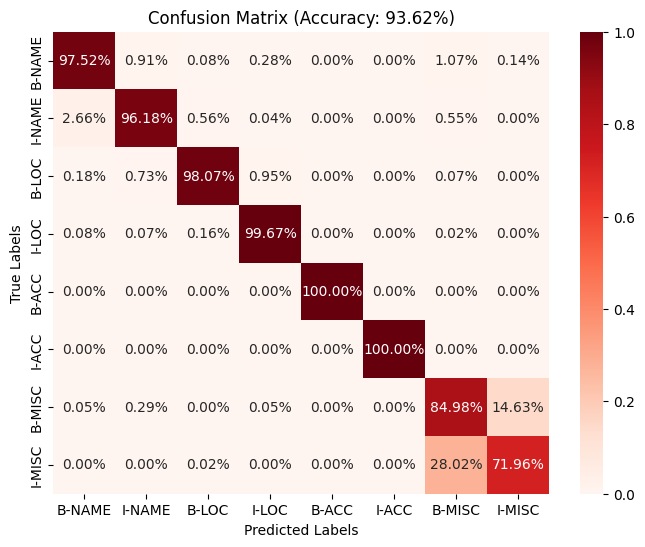

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Reds")

# Get class labels from indexes using the idx_to_class dictionary
class_labels = [index_to_class[label_idx] for label_idx in sorted(set(true_labels))]

plt.title("Confusion Matrix (Accuracy: {:.2%})".format(accuracy))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Set x-axis and y-axis labels using class labels
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.yticks(np.arange(len(class_labels))+ 0.5, class_labels)

plt.show()

## Testing the model on a random sentence

In [ ]:
def most_frequent(lst):
    """
    Returns the most frequent value in a list.

    Args:
        lst (list): A list of values.

    Returns:
        The most frequent value in the list.
    """
    # Create a dictionary to store the count of each value in the list
    counts = {}
    for item in lst:
        if item in counts:
            counts[item] += 1
        else:
            counts[item] = 1

    # Find the most frequent value in the dictionary
    max_count = 0
    max_item = None
    for item, count in counts.items():
        if count > max_count:
            max_count = count
            max_item = item

    return max_item

In [ ]:
from collections import defaultdict

f = open('/content/drive/MyDrive/CRP/master_dict_output_BERT_patterned_v2.json')
data = json.load(f)

n = len(data['annotations'])
random_ex = data['annotations'][np.random.randint(n)]
example_sequence = random_ex[1]





def test(example_sequence):
    print(f' Trying to pass the following sequence : {example_sequence}')
    print('The predicted classes for the sequence by the BiLSTM are :')
    if type(example_sequence) == str : 
      example_sequence = example_sequence.split(" ")
    
    sample_dataset = Dataset.from_dict({"tokens": example_sequence})

    def tokenize(example):
        tokenized_inputs = tokenizer(example_sequence, truncation=True, is_split_into_words=True) 
        word_ids = tokenized_inputs.word_ids(batch_index=0)
        tokenized_inputs['word_ids'] = word_ids
        return tokenized_inputs

    tokenized_inputs = sample_dataset.map(tokenize)

    inputs_ids = torch.tensor(tokenized_inputs["input_ids"]).to(device)
    
    attention_mask = torch.tensor(tokenized_inputs["attention_mask"]).to(device)

    output = model(inputs_ids, attention_mask)
    preds = predict_labels(output, attention_mask)
    preds = preds[0]
    

    word_ids = tokenized_inputs['word_ids'][0]

    word_dict = defaultdict(list)
    index = 0
    for _, id in enumerate(word_ids):
        if id is not None:
            word_dict[id].append(preds[index])
            index+=1

    final_dict = {}
    for key, value in word_dict.items() :
      final_dict[example_sequence[key]] = index_to_class[most_frequent(value)]


    return final_dict

print(test("Corentin Delloye 14 Allée du Bord de l'eau FR76 1883 2390 3894 2893"))


 Trying to pass the following sequence : Corentin Delloye 14 Allée du Bord de l'eau FR76 1883 2390 3894 2893
The predicted classes for the sequence by the BiLSTM are :


Map:   0%|          | 0/13 [00:00<?, ? examples/s]

{'Corentin': 'B-NAME', 'Delloye': 'I-NAME', '14': 'B-LOC', 'Allée': 'I-LOC', 'du': 'I-LOC', 'Bord': 'I-LOC', 'de': 'I-LOC', "l'eau": 'I-LOC', 'FR76': 'I-LOC', '1883': 'I-ACC', '2390': 'I-ACC', '3894': 'I-ACC', '2893': 'I-ACC'}
